In [2]:
#Importar librerías.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
plt.style.use('fivethirtyeight')
from bs4 import BeautifulSoup
import requests
import datetime
import pyarrow
import openmeteo_requests

import requests_cache

from retry_requests import retry
import warnings
warnings.filterwarnings('ignore')

In [3]:


# Configura el cliente API Open-Meteo con caché y vuelve a intentarlo en caso de error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Todas las variables climáticas requeridas se enumeran aquí

url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"current": ["us_aqi", "pm10", "pm2_5", "carbon_monoxide", "sulphur_dioxide", "ozone"],
	"hourly": ["pm10", "pm2_5", "carbon_monoxide", "sulphur_dioxide", "ozone", "us_aqi", "us_aqi_pm2_5", "us_aqi_pm10", "us_aqi_carbon_monoxide", "us_aqi_ozone"],
	"timezone": "America/New_York",
	"start_date": "2023-12-01",
	"end_date": "2024-02-29"
}
responses = openmeteo.weather_api(url, params=params)

# Ubicación del proceso.
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Para lo valores actuales, el orden de las variables debe ser el mismo que el solicitado.
current = response.Current()
current_us_aqi = current.Variables(0).Value()
current_pm10 = current.Variables(1).Value()
current_pm2_5 = current.Variables(2).Value()
current_carbon_monoxide = current.Variables(3).Value()
current_sulphur_dioxide = current.Variables(4).Value()
current_ozone = current.Variables(5).Value()

print(f"Current time {current.Time()}")
print(f"Current us_aqi {current_us_aqi}")
print(f"Current pm10 {current_pm10}")
print(f"Current pm2_5 {current_pm2_5}")
print(f"Current carbon_monoxide {current_carbon_monoxide}")
print(f"Current sulphur_dioxide {current_sulphur_dioxide}")
print(f"Current ozone {current_ozone}")

# Para procesar datos horarios, el orden de las variables debe ser el mismo que el solicitado.
hourly = response.Hourly()
hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
hourly_carbon_monoxide = hourly.Variables(2).ValuesAsNumpy()
hourly_sulphur_dioxide = hourly.Variables(3).ValuesAsNumpy()
hourly_ozone = hourly.Variables(4).ValuesAsNumpy()
hourly_us_aqi = hourly.Variables(5).ValuesAsNumpy()
hourly_us_aqi_pm2_5 = hourly.Variables(6).ValuesAsNumpy()
hourly_us_aqi_pm10 = hourly.Variables(7).ValuesAsNumpy()
hourly_us_aqi_carbon_monoxide = hourly.Variables(8).ValuesAsNumpy()
hourly_us_aqi_ozone = hourly.Variables(9).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["pm10"] = hourly_pm10
hourly_data["pm2_5"] = hourly_pm2_5
hourly_data["carbon_monoxide"] = hourly_carbon_monoxide
hourly_data["sulphur_dioxide"] = hourly_sulphur_dioxide
hourly_data["ozone"] = hourly_ozone
hourly_data["us_aqi"] = hourly_us_aqi
hourly_data["us_aqi_pm2_5"] = hourly_us_aqi_pm2_5
hourly_data["us_aqi_pm10"] = hourly_us_aqi_pm10
hourly_data["us_aqi_carbon_monoxide"] = hourly_us_aqi_carbon_monoxide
hourly_data["us_aqi_ozone"] = hourly_us_aqi_ozone

hourly_dataframe = pd.DataFrame(data = hourly_data)


Coordinates 40.80000305175781°N -74.0°E
Elevation 51.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
Current time 1715292000
Current us_aqi 28.489580154418945
Current pm10 17.200000762939453
Current pm2_5 12.0
Current carbon_monoxide 285.0
Current sulphur_dioxide 5.199999809265137
Current ozone 65.0


In [4]:
hourly_dataframe.head()

,date,pm10,pm2_5,carbon_monoxide,sulphur_dioxide,ozone,us_aqi,us_aqi_pm2_5,us_aqi_pm10,us_aqi_carbon_monoxide,us_aqi_ozone
0,2023-12-01 04:00:00+00:00,11.1,7.7,277.0,8.8,30.0,47.638889,47.638889,14.844696,1.042673,3.014842
1,2023-12-01 05:00:00+00:00,11.1,7.7,270.0,8.2,33.0,46.250008,46.250008,14.412878,1.027375,2.956864
2,2023-12-01 06:00:00+00:00,11.4,8.0,265.0,7.8,35.0,44.965279,44.965279,14.018939,1.005636,3.092146
3,2023-12-01 07:00:00+00:00,11.9,8.3,258.0,7.7,34.0,43.871525,43.871525,13.678031,0.979066,3.382035
4,2023-12-01 08:00:00+00:00,12.4,8.7,253.0,7.8,32.0,42.881943,42.881943,13.371211,0.947263,3.768553


In [5]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   date                    2184 non-null   datetime64[ns, UTC]
 1   pm10                    2184 non-null   float32            
 2   pm2_5                   2184 non-null   float32            
 3   carbon_monoxide         2184 non-null   float32            
 4   sulphur_dioxide         2184 non-null   float32            
 5   ozone                   2184 non-null   float32            
 6   us_aqi                  2184 non-null   float32            
 7   us_aqi_pm2_5            2184 non-null   float32            
 8   us_aqi_pm10             2184 non-null   float32            
 9   us_aqi_carbon_monoxide  2184 non-null   float32            
 10  us_aqi_ozone            2184 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(10)
memo

In [11]:
print(f'Año con menor CO2:',hourly_dataframe['date'].min(sum('carbon_monoxide')),' Año con mayor CO2:',hourly_dataframe['date'].max(sum('carbon_monoxide'))

SyntaxError: incomplete input (1847269040.py, line 1)

In [ ]:
hourly_dataframe.

In [6]:
# Se crea Subplot 
fig, ax = plt.subplots(1, 1, figsize=(20, 12),dpi=800)

# grafica1 Particulas por metro cubico

sns.lineplot(x="date", y="pm2_5", data=hourly_dataframe, 
            ax=ax, markers=True, palette="magma")
    # etiquetas & ejes
ax.set_xlabel('años')
ax.set_ylabel('PM 2.5 µg / cm3')
ax.set_title('Particulas finas en el aire New York')
    # Leyenda
ax.legend(title='Calidad del aire', loc='upper right', bbox_to_anchor=(1.05, 1)) 
    # Lineas de standar
ax.axhline(y=10, color='red', linestyle='--',label='standard OMS')
ax.axhline(y=12, color='green', linestyle='--',label='standard EPA')
    # leyenda a la línea
ax.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


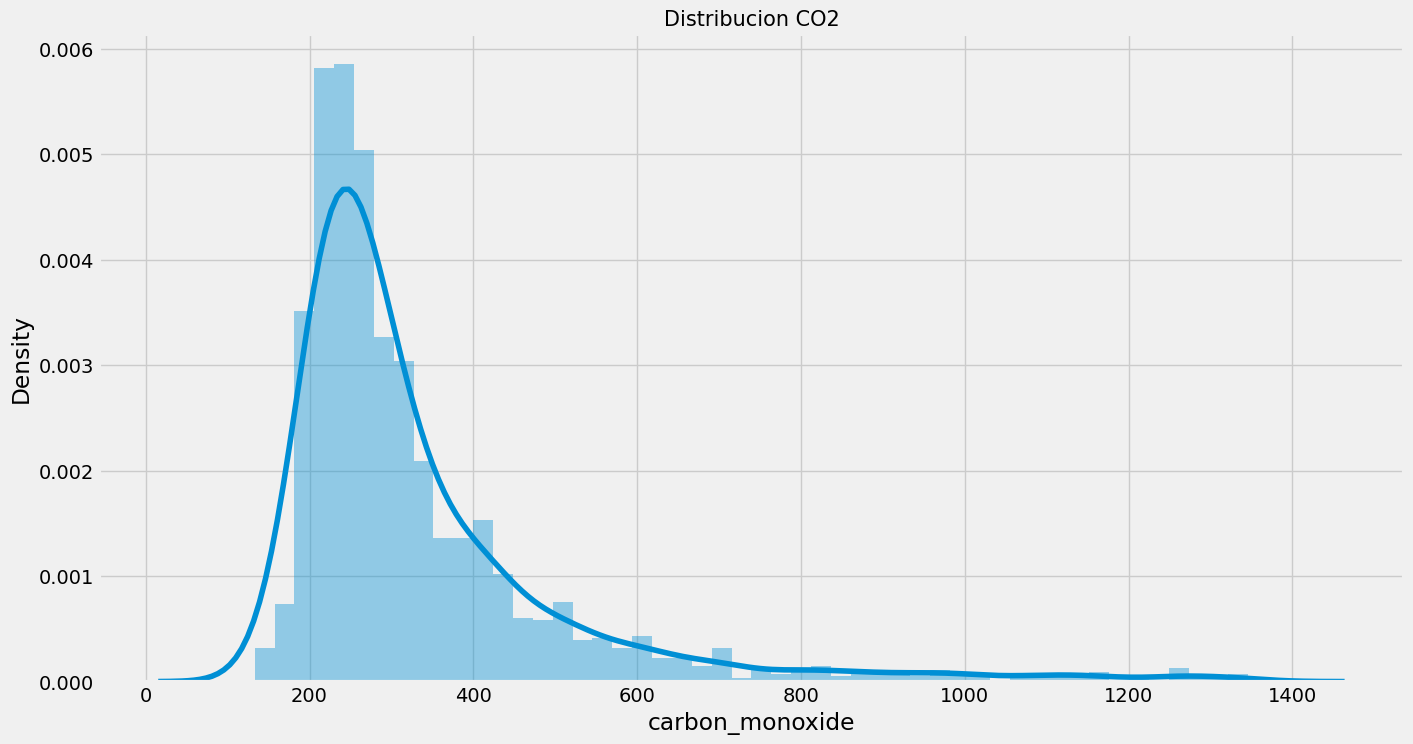

In [15]:
# Grafico ditribucion CO2

plt.subplots(figsize=(15,8))

sns.distplot(hourly_dataframe['carbon_monoxide'])
plt.title('Distribucion CO2',size=15)
plt.show()